# Data lab 3 - Portfolio Value-at-Risk

#### Note 1: Review what you have learned in Data lab 2, DataCamp assignments, and in-class sample code.
#### Note 2: Chapter "Value at Risk" of DataCamp course "Introduction to Portfolio Risk Management in Python"  is a useful reference.
#### Note 3: This note serves as a guide. You are free to tinker with it! 

### 1. Revisit the all-weather portfolio you crafted. Put the portfolio daily and cumulative returns of the three portfolios (i.e., equally-weighted, maximum Sharpe, or minimum volatility) side-by-side in a dataframe.

#### If you have attempted the optional bonus, why not include the portfolios with L2 regularization and Black-Litterman model too.

In [46]:
# Import the necessary packages
import yfinance as yf
import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Place the list of stocks that form your all-weather portfolio in Data Lab 2
# Draw data for the past five years
symbols_list = ["AAPL", "AMZN", "GOOG", "BP", "KMI", "BABA", "TCEHY", "BYDDY", "TSLA", "JPM"] ## List of stocks picked

start = dt.datetime(2017,8,31)      ## Specify the starting point of historical price
end = dt.datetime(2022,8,31)      ## Specify the ending point of historical price

price = yf.download(symbols_list, start=start, end=end)['Adj Close']      ## Download the price data and keep only the adjusted closing price


# Calculate return using method pct_change
return_df = price.pct_change()

# function that takes portfolio weights and creates a time-series of daily portfolio returns
def portfolio_return_series(daily_returns, weights):

    '''
    INPUTS
    daily returns: dataframe of daily returns. Each ticker column contains the series of daily returns for the ticker
    weights: numpy array of the portfolio weight on each ticker (sorted in ascending order)

    OUTPUTS
    portfolio_daily_returns: the portfolio return series given the weights
    portfolio_cumulative_returns: the portfolio cumulative return series given the weights

    '''

    # Create portfolio daily returns
    port_return = daily_returns.dot(weights)

    # Calculate cumulative returns
    cuml_return = (1 + port_return).cumprod() - 1

    return port_return, cuml_return

[*********************100%***********************]  10 of 10 completed


In [4]:
# Import the packages
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

The Maximum Sharpe Portfolio

In [47]:
# Calculate expected returns mu 
mu = expected_returns.mean_historical_return(price)

# Calculate the covariance matrix S
sigma = risk_models.sample_cov(price)

# Obtain the efficient frontier
ef = EfficientFrontier(mu, sigma)

# Calculate weights for the maximum Sharpe ratio portfolio
ef.max_sharpe()
weights_sharpe = np.array(list(ef.clean_weights().values()))

# Inspect the calculated weights
print(weights_sharpe)

[0.5468  0.      0.      0.      0.16437 0.      0.      0.      0.
 0.28882]


The minimum volatility portfolio

In [48]:
# Obtain the efficient frontier
ef = EfficientFrontier(mu, sigma)

# Calculate weights for the minimum volatility portfolio
ef.min_volatility()
weights_vol = np.array(list(ef.clean_weights().values()))

# Inspect the calculated weights
print(weights_vol)

[0.07544 0.18424 0.00156 0.0606  0.00593 0.16251 0.16896 0.24302 0.09775
 0.     ]


In [49]:
# 1. Daily portfolio returns for the equally-weighted portfolio
weights_equal = np.array([0.1]*10)

# Extract from the function output for daily returns and cumulative returns
return_equal, cuml_equal = portfolio_return_series(return_df, weights_equal)

# 2. Daily portfolio returns for the maximum Sharpe portfolio
# Extract from the function output for daily returns and cumulative returns
return_sharpe, cuml_sharpe = portfolio_return_series(return_df, weights_sharpe)

# 3. Daily portfolio returns for the minimum volatility portfolio
# Extract from the function output for daily returns and cumulative returns
return_vol, cuml_vol = portfolio_return_series(return_df, weights_vol)

# Merge the six series side-by-side into a dataframe
# Note the index is date
port_returns = pd.concat([return_equal, return_sharpe, return_vol,
                         cuml_equal, cuml_sharpe, cuml_vol], axis=1).dropna()

# Rename column names
names = ['Equal(R)', 'Sharpe(R)', 'Volatility(R)',
         'Equal(C)', 'Sharpe(C)', 'Volatility(C)']

port_returns.columns = names

# Inspect the first five rows of the dataframe (e.g., portfolio_returns)
port_returns.head()

,Equal(R),Sharpe(R),Volatility(R),Equal(C),Sharpe(C),Volatility(C)
Date,,,,,,
2017-08-31,0.006007,0.003172,0.008547,0.006007,0.003172,0.008547
2017-09-01,-0.000420,0.000036,0.000431,0.005584,0.003208,0.008982
2017-09-05,-0.011321,-0.013071,-0.011304,-0.005800,-0.009905,-0.002423
2017-09-06,0.002934,-0.001980,0.003881,-0.002882,-0.011865,0.001448
2017-09-07,0.002413,0.003993,-0.002480,-0.000476,-0.007920,-0.001035


### 2. Examine visually the drawdown behavior of each portfolio.


Text(0.5, 1.0, 'Volatility Optimal')

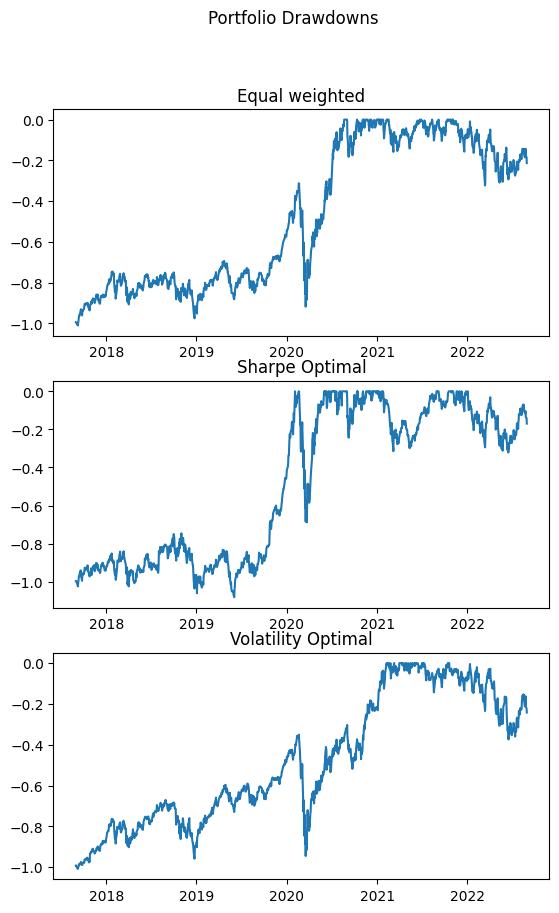

In [50]:
# function that takes portfolio weights and creates a time-series of daily portfolio returns
def portfolio_drawdown(cumulative_portfolio_returns):
    
    ''' 
    INPUTS
    cumulative_portfolio_returns: the portfolio cumulative return series
    
    OUTPUTS
    percentage drawdown series
    
    '''    

    # Calculate the running maximum
    running_max = np.maximum.accumulate(np.array(cumulative_portfolio_returns))

    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1

    # Calculate the percentage drawdown
    drawdown = cumulative_portfolio_returns / running_max - 1
    
    return drawdown

# Adding adjustments to the plots later
fig, axs = plt.subplots(3)      ## Use three subplots
fig.suptitle('Portfolio Drawdowns')      ## Set the major title for the three subplots
fig.set_figheight(10)      ## Set the height of the overall plot larger so that each subplot is visible

# Plot the first subplot for equally weighted portfolio
axs[0].plot(port_returns.index, portfolio_drawdown(port_returns['Equal(C)']))
axs[0].set_title('Equal weighted')

# Plot the second for the sharpe optimal portfolio
axs[1].plot(port_returns.index, portfolio_drawdown(port_returns['Sharpe(C)']))
axs[1].set_title('Sharpe Optimal')

# Plot the third for the volatility optimal portfolio
axs[2].plot(port_returns.index, portfolio_drawdown(port_returns['Volatility(C)']))
axs[2].set_title('Volatility Optimal')


### 3. Calculate the Value-at-Risk of each portfolio at 99% using the empirical (historical) distribution and theoretical distribution. Create graphs that show the empirical distribution with two vertical lines, representing the Value-at-Risk at 99% derived from the empirical and theoretical distribution, respectively.


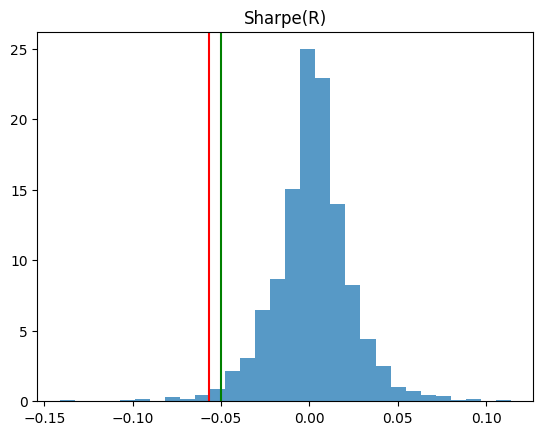

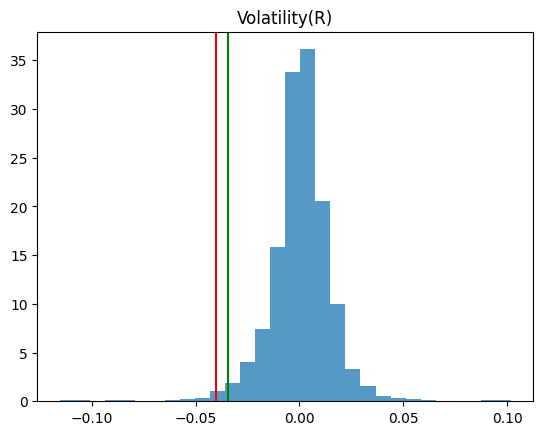

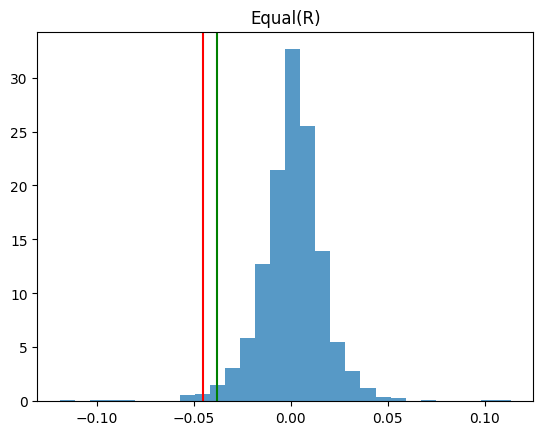

(1, -0.04505305629760574, -0.03825483838278114)

In [53]:
# Import norm from scipy.stats
from scipy.stats import norm

# function that takes portfolio weights and creates a time-series of daily portfolio returns
def portfolio_var(daily_portfolio_returns, level):
    
    ''' 
    INPUTS
    daily_portfolio_returns: the portfolio daily return series
    level: tail risk at 90%, 95%, or 99% ## enter 90 for 90% and so on!
    
    OUTPUT
    Empirical VaR: Value at Risk of the portfolio using the empirical distribution 
                   at the specified level (e.g., 90%, 95%, or 99%)
    Theoretical VaR: Value at Risk of the portfolio using mathematical formulas (sampling distribution) 
                     at the specified level (e.g., 90%, 95%, or 99%)
    Plot object: empirical distribution of returns with 
                 two lines indicating the empirical and theoretical VaRs at the specified level
    
    '''    

    # Calculate the tail risk (i.e., 100 - level)
    tail_risk = 100 - level
    
    # Calculate empirical historical VaR at specified level
    var_empirical = np.percentile(daily_portfolio_returns, tail_risk)
    
    # Calculate theoretical VaR at specified level
    # Note the norm.ppf function takes argument tail risk of 99% in 0.99, instead of 99
    var_theoretical = norm.ppf(tail_risk/100,
                               np.mean(daily_portfolio_returns),
                               np.std(daily_portfolio_returns))

    # Plot the probability of each sorted return quantile
    plt.hist(daily_portfolio_returns, 30, density=True, alpha=0.75)

    plt.title(daily_portfolio_returns.name)
    # Denote the VaR 99 quantile and plot the vertical lines
    plt.axvline(x=var_empirical, color='r', linestyle='-')
    plt.axvline(x=var_theoretical, color='g', linestyle='-')
    plt.show()
    
    return tail_risk, var_empirical, var_theoretical

# Call the function to calculate and plot VaR for the Maximum Sharpe Portfolio at 99%
portfolio_var(port_returns['Sharpe(R)'], 99)

# Call the function to calculate and plot VaR for the Minimum Volatility Portfolio at 99%
portfolio_var(port_returns['Volatility(R)'], 99)

# Call the function to calculate and plot VaR for the Equally Weighted Portfolio at 99%
portfolio_var(port_returns['Equal(R)'], 99)

### 4. Is the portfolio return for the maximum Sharpe portfolio statistically different from that of the equally-weighted portfolio?

In [57]:
# Import pingouin - a simple but powerful statistical package
import pingouin as pg

# Conduct an independent t-test on equally-weighted portfolio and max sharpe portfolio
# The null hypothesis is that their mean returns are equal

independent = pg.ttest(port_returns['Sharpe(R)'], port_returns['Volatility(R)'], confidence=0.99).round(3)
independent

,T,dof,alternative,p-val,CI99%,cohen-d,BF10,power
T-test,1.539,2514,two-sided,0.124,"[-0.0007871833984241427, 0.0031210773604091043]",0.061,0.146,0.337


##### Qiaozheng Lu: As shown in the output, the independent t-test yields a relatively high p value at 0.124, meaning that it is hard for us to reject the null. Hence, the independent t-test suggests that the means of the daily returns of teh equally weighted and the sharpe maximized portfolio is not significantly different from each other.

In [58]:
# Print the paired test results
paired = pg.ttest(port_returns['Sharpe(R)'], port_returns['Volatility(R)'],
         paired=True, confidence=0.99).round(3)
paired

,T,dof,alternative,p-val,CI99%,cohen-d,BF10,power
T-test,2.713,1257,two-sided,0.007,"[5.714274368440398e-05, 0.002276751218300559]",0.061,1.234,0.585


##### Qiaozheng Lu: The paired test suggest a totally different story. With a p value of 0.007, we can reject the null at a 1\% confidence level. The mean daily return is highly probable to differ between the two allocations.

##### Qiaozheng Lu: Also, the difference in the output of two tests suggests that the two allocation is not independent. Instead, they can be highly correlated so that the paired test is more countable.


#### Optional Bonus: Additional Test for The Curious: The equality of mean portfolio returns across equally weighted, maximum-Sharpe, and minimum-volatility portfolios.

In [158]:
# Strip out the daily returns to form a new dataframe
port_returns_daily = port_returns.iloc[: , 0: 3]

# Reshape the dataframe, such that we have a column for portfolio type
port_returns_daily = port_returns_daily.unstack()
port_returns_daily.head()


          Date      
Equal(R)  2017-08-31    0.006007
          2017-09-01   -0.000420
          2017-09-05   -0.011321
          2017-09-06    0.002934
          2017-09-07    0.002413
dtype: float64

In [159]:
# Turn multiindex into columns
# Hint: reset the index with dataframe's method .reset_index()
port_returns_daily = port_returns_daily.reset_index()

# Set the Date column as the new index
port_returns_daily.set_index('Date', inplace=True)

# Rename column names
names2 = ['Type', 'Daily Return']

port_returns_daily.columns = names2

# Inspect dataframe
port_returns_daily.head()

,Type,Daily Return
Date,,
2017-08-31,Equal(R),0.006007
2017-09-01,Equal(R),-0.000420
2017-09-05,Equal(R),-0.011321
2017-09-06,Equal(R),0.002934
2017-09-07,Equal(R),0.002413


In [161]:
# Test the equality of portfolio mean returns across three portfolio construction methods
# The null hypothesis is that their mean returns are equal
anova = pg.anova(data=port_returns_daily, dv='Daily Return', between='Type', detailed=True).round(3)

anova


,Source,SS,DF,MS,F,p-unc,np2
0,Type,0.001,2,0.0,1.398,0.247,0.001
1,Within,1.266,3771,0.0,NaN,NaN,NaN


##### Qiaozheng Lu: As shown in the output table, the uncorrected p-value is 0.247, which is too high for us to reject the null. This ANOVA analysis suggests that the mean of the daily return does not significantly vary across different allocation methods.

##### Qiaozheng Lu: In the meantime, given the difference in the two t-tests, the correlation between those allocations can introduce bias to the tests. Is it possible that the correlation is messing the ANOVA analysis? More in-depth inspect shown in the next question.

### 5. Optional Bonus. What other hypotheses would you like to test? How do you test them? What do you find?

#### Q1: Is the portfolios is significantly better / worse than the market index?
Here is how I have done it:

In [78]:
# Download the historical price data of the SP500 index from YFinance API
# It's weird that there is no intuitive ticker that leads directly to the index.
# Here I used an actively traded ETF on the SP500 as a proxy.
sp500 = yf.download('SPY', start, end)['Adj Close']

# Caluculate the daily return
sp_return = sp500.pct_change().dropna()

# Strip out the daily returns to form a new dataframe, because the codes before messed it up
port_returns_daily = port_returns.iloc[: , 0: 3]

# Concatenate
port_returns_daily = pd.concat([port_returns_daily, sp_return], axis=1)

# Rename the SP500 column
port_returns_daily.rename(columns={'Adj Close': 'Market'}, inplace=True)

# Inspect
port_returns_daily.head()


[*********************100%***********************]  1 of 1 completed


,Equal(R),Sharpe(R),Volatility(R),Market
Date,,,,
2017-08-31,0.006007,0.003172,0.008547,0.006016
2017-09-01,-0.000420,0.000036,0.000431,0.001414
2017-09-05,-0.011321,-0.013071,-0.011304,-0.007182
2017-09-06,0.002934,-0.001980,0.003881,0.003414
2017-09-07,0.002413,0.003993,-0.002480,-0.000122


1) Equally weighted vs. Market

In [83]:
# Perform the paired t-test
# One-sided. Alternative: Mean of Equally-weighted is greater than that of the market
E_M = pg.ttest(port_returns_daily['Equal(R)'], port_returns_daily['Market'],
         alternative='greater', paired=True, confidence=0.99).round(3)
E_M

,T,dof,alternative,p-val,CI99%,cohen-d,BF10,power
T-test,1.572,1257,greater,0.058,"[-0.00019728412300881311, inf]",0.027,0.218,0.248


##### Qiaozheng Lu: As the null is that the means are equal, the p value of 0.058 suggests that, at least on a 10\% level, we can say that the equally-weighted portfolio is better than the market in terms of mean daily return.

2) Sharpe vs. Market

In [85]:
# One-sided. Alternative: Mean of Shapre is greater than that of the market
S_M = pg.ttest(port_returns_daily['Sharpe(R)'], port_returns_daily['Market'],
         alternative='greater', paired=True, confidence=0.99).round(3)
S_M

,T,dof,alternative,p-val,CI99%,cohen-d,BF10,power
T-test,3.011,1257,greater,0.001,"[0.00029585987230706587, inf]",0.072,5.761,0.814


##### Qiaozheng Lu: The sharpe optimal is definitely better than the market!!!

3) Volatility vs. Market

In [89]:
# One-sided. Alternative: Mean of Volatility is greater than that of the market
V_M = pg.ttest(port_returns_daily['Volatility(R)'], port_returns_daily['Market'],
         alternative='greater', paired=True, confidence=0.99).round(3)
V_M

,T,dof,alternative,p-val,CI99%,cohen-d,BF10,power
T-test,0.793,1257,greater,0.214,"[-0.0002700925002221818, inf]",0.01,0.087,0.098


##### Qiaozhen Lu: So sad that the price you have to pay for the low volatility is to obtain only the market return.

#### Q2: Is the result of the ANOVA analysis messed up by the correlation?
Here is how I do it.

In the case where the groups are dependent on each other, the equivalent of the one-way ANOVA is the repeated measures ANOVA.

Based on what I have learned from Google about the repeated ANOVA, in our case, the subjects are the dates, and the groups are the three allocations.

The null hypothesis we are testing is that the mean daily return is the same for all allocations. The alternative is that they are significantly different from each other.

In [162]:
# Strip out the daily returns to form a new dataframe
# Redoing this because the previous codes messed the dataframe
port_returns_daily = port_returns.iloc[: , 0: 3]

# Reshape the dataframe, such that we have a column for portfolio type
port_returns_daily = port_returns_daily.unstack()

# Reset the index of the dataframe
port_returns_daily = port_returns_daily.reset_index()

# Rename column names
# Here I kept the date column instead of indexing it
# Because the repeated ANOVA requires specifying the subjects, which is the date
names3 = ['Type', 'Date', 'Daily Return']

port_returns_daily.columns = names3

# Inspect dataframe
port_returns_daily.head()


,Type,Date,Daily Return
0,Equal(R),2017-08-31,0.006007
1,Equal(R),2017-09-01,-0.000420
2,Equal(R),2017-09-05,-0.011321
3,Equal(R),2017-09-06,0.002934
4,Equal(R),2017-09-07,0.002413


In [164]:
anova2 = pg.rm_anova(data=port_returns_daily, dv='Daily Return', within='Type', subject='Date').round(3)

anova2


C:\Users\Qiaozheng Lu\Desktop\S01\S01_Assignments\BMF 5324\Individual Data Lab 1 (Practice) - Financial Concepts\venv\lib\site-packages\pingouin\distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,Type,2,2514,7.096,0.001,0.001,0.594


##### Qiaozheng Lu: Though some warning is report (which I have no idea why), the repeated ANOVA suggests that the mean daily return is significantly different from each other.